[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/gan_practice/blob/master/dcgan.ipynb)


In [1]:
!pip install --upgrade tensorflow==2

     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
     |████████████████████████████████| 3.8MB 59.9MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [0]:
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,\
Activation, Dropout, Flatten, Dense, Reshape, UpSampling2D, LeakyReLU,\
ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [0]:
img_dirs_list = []
img_files_path = []

dataset_path = ""
img_dirs_list = glob(dataset_path + "/*")
for dir_path in img_dirs_path:
    imgs_path = glob8(glob + "/*")
    img_files_path.append(imgs_path)

print("# of images:", len(img_files_path))

In [0]:
x_train = np.array(img_files_path)

In [0]:
x_train = x_train/127.5 - 1.0
x_train = np.expand_dims(x_train, -1)
x_train.shape

(60000, 28, 28, 1)

In [0]:
# hyper params
input_dims = (128, 128, 3)
num_disc_layers = 4
disc_conv_fils = [32, 64, 128, 256]
disc_conv_kernel_size = [3, 3, 3, 3]
disc_conv_strides = [2, 2, 2, 1]
disc_batch_norm_momentum = 0.8
disc_dropout_rate = 0.25

z_dims = 100
shape_after_dense = (7, 7, 128)
gen_upsamp_layers = [True, True, False]
gen_batch_norm_momentum = 0.8
gen_dropout_rate = None
num_gen_layers = 3
gen_conv_fils = [128, 64, 1]
gen_conv_kernel_size = [3, 3, 3]

## Discriminator

In [0]:
disc_input = Input(shape=input_dims, name="disc_input")
x = disc_input

for i in range(num_disc_layers):
    x = Conv2D(filters=disc_conv_fils[i],
              kernel_size=disc_conv_kernel_size[i],
              strides=disc_conv_strides[i],
              padding="same",
              name="disc_conv_" + str(i)
              )(x)
    
    if i == 1:
        """
        Arguments:
        padding: Int, or tuple of 2 ints, or tuple of 2 tuples of 2 ints.
        If int: the same symmetric padding is applied to height and width.
        If tuple of 2 ints: interpreted as two different symmetric padding values for height and width: (symmetric_height_pad, symmetric_width_pad).
        If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
        """
        x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
        
    if disc_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum=disc_batch_norm_momentum)(x)
        
    x = LeakyReLU(alpha=0.2)(x)
    
    if disc_dropout_rate:
        x = Dropout(disc_dropout_rate)(x)
    
x = Flatten()(x)
disc_output = Dense(1, activation="sigmoid")(x)
disc_model = Model(disc_input, disc_output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
disc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_input (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
disc_conv_0 (Conv2D)         (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256   

## Generator

In [0]:
gen_input = Input(shape=(z_dims,), name="gen_input")
x = gen_input
x = Dense(np.prod(shape_after_dense))(x)
    
x = Activation("relu")(x)
x = Reshape(shape_after_dense)(x)
    
for i in range(num_gen_layers):
    if gen_upsamp_layers[i]:
        x = UpSampling2D()(x)
        
    x = Conv2D(gen_conv_fils[i],
              gen_conv_kernel_size[i],
              padding="same",
              name="gen_conv_" + str(i)
              )(x)
    
    if i < num_gen_layers - 1:
        if gen_batch_norm_momentum:
            x = BatchNormalization(
            momentum=gen_batch_norm_momentum)(x)
            
        x = Activation("relu")(x)
    else:
        x = Activation("tanh")(x)
        
gen_output = x
gen_model = Model(gen_input, gen_output)

In [0]:
gen_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation (Activation)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
gen_conv_0 (Conv2D)          (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512 

## Train the GAN

### compile discriminator train model

In [0]:
disc_model.compile(#optimizer=RMSprop(lr=0.0008),
                  optimizer=Adam(0.0002, 0.5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# freeze the discriminator model so that it only makes
# the generator model train on this model
disc_model.trainable = False
comb_model_input = Input(shape=(z_dims,), name="comb_model_input")
comb_model_output = disc_model(gen_model(comb_model_input))
comb_model = Model(comb_model_input, comb_model_output)

### compile generator train model

In [0]:
comb_model.compile(#optimizer=RMSprop(0.0004),
             optimizer=Adam(0.0002, 0.5),
             loss="binary_crossentropy",
             metrics=["accuracy"])

In [0]:
def train_disc(disc_model, gen_model, x_train, batch_size):
    # create 2-dim labels
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    
    # train on real imgs
    # np.random.randint(min, max, size)
    idxes = np.random.randint(0, len(x_train), batch_size)
    real_imgs = x_train[idxes]
    
    disc_real_loss = disc_model.train_on_batch(real_imgs, real_labels)
    
    # train on fake imgs
    # np.random.normal(mean, std, size)
    # the blow follows the standard normal distribution
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    fake_imgs = gen_model.predict(noise)
    
    disc_fake_loss = disc_model.train_on_batch(fake_imgs, fake_labels)
    disc_loss = 0.5 * np.add(disc_real_loss, disc_fake_loss)
    return disc_loss

In [0]:
def train_gen(comb_model, batch_size):
    real_labels = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, z_dims))
    
    gen_loss = comb_model.train_on_batch(noise, real_labels)
    return gen_loss

In [0]:
def plot_generated_imgs(rows, cols, noises, it, gen_model):
    print("iteration: ", it)

    gen_imgs = gen_model.predict(noises)

    # since gen model outputs values ranging from -1 to 1,
    # nomalize imgs ranging from 0 to 1
    #=====================================================================
    # matplotlib.pyplot.imshow(..., norm=None, ...):
    # By default, a linear scaling mapping the lowest value to 0 and
    # the highest to 1 is used. This parameter is ignored for RGB(A) data.
    #=====================================================================

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(rows, cols)

    ith_img = 0
    for row in range(rows):
        for col in range(cols):
            try:
                axs[row, col].imshow(gen_imgs[ith_img,:,:,0], cmap="gray")
                axs[row, col].axis("off")
                ith_img += 1
            except IndexError:
                axs[col].imshow(gen_imgs[ith_img,:,:,0], cmap="gray")
                axs[col].axis("off")
                ith_img += 1

[training log]
iteration: 0 disc loss: 1.028140, disc acc: 37.50% | gen loss: 0.867542, gen acc: 0.42%
iteration:  0
iteration: 1000 disc loss: 0.663162, disc acc: 59.38% | gen loss: 1.028163, gen acc: 0.23%
iteration:  1000
iteration: 2000 disc loss: 0.649516, disc acc: 56.25% | gen loss: 0.934904, gen acc: 0.30%
iteration:  2000
iteration: 3000 disc loss: 0.709500, disc acc: 53.12% | gen loss: 0.916895, gen acc: 0.36%
iteration:  3000
iteration: 4000 disc loss: 0.688876, disc acc: 57.03% | gen loss: 0.987680, gen acc: 0.20%
iteration:  4000
iteration: 5000 disc loss: 0.684094, disc acc: 55.47% | gen loss: 0.877287, gen acc: 0.25%
iteration:  5000
iteration: 6000 disc loss: 0.742788, disc acc: 45.31% | gen loss: 0.829910, gen acc: 0.38%
iteration:  6000
iteration: 7000 disc loss: 0.752818, disc acc: 44.53% | gen loss: 0.876452, gen acc: 0.39%
iteration:  7000
iteration: 8000 disc loss: 0.660208, disc acc: 57.81% | gen loss: 0.914548, gen acc: 0.34%
iteration:  8000
iteration: 9000 dis

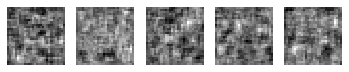

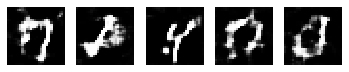

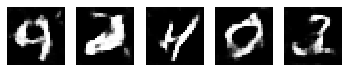

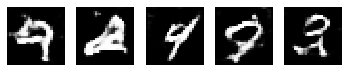

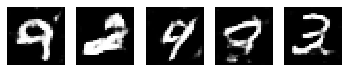

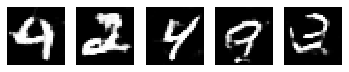

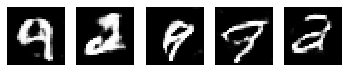

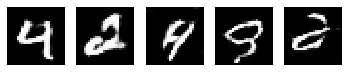

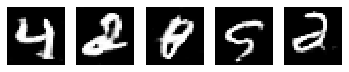

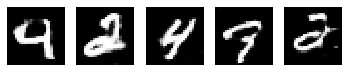

In [0]:
iterations = 10_000
batch_size = 64
rows, cols = 1, 5
noises = np.random.normal(0, 1, (rows * cols, z_dims))

print("[training log]")
for it in range(iterations):
    disc_loss = train_disc(disc_model, gen_model, x_train, batch_size)
    gen_loss = train_gen(comb_model, batch_size)
    
    if it % 1000 == 0:
        print("iteration: %d disc loss: %f, disc acc: %.2f%% | gen loss: %f, "
        "gen acc: %.2f%%" % 
          (it, disc_loss[0], 100 * disc_loss[1], gen_loss[0], gen_loss[1]))
        plot_generated_imgs(rows, cols, noises, it, gen_model)
        
print("[5 generated images for each 1000th iteration]")